## Modelagem de topicos através do tempo

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import unicodedata
from umap import UMAP
from hdbscan import HDBSCAN
import os
import numpy as np

[nltk_data] Downloading package stopwords to /home/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
comments = pd.read_csv("comments_filtered.csv")
print(comments[['created_timestamp_utc']].head())
comments['month'] = pd.to_datetime(comments['created_timestamp_utc']).dt.to_period('M').astype(str)
comments['type'] = 'C'

date_month_com = comments['month']

  created_timestamp_utc
0   2022-01-01 19:16:14
1   2022-01-01 19:16:20
2   2022-01-01 20:33:19
3   2022-01-01 23:30:43
4   2022-01-02 01:08:38


In [49]:
submissions = pd.read_csv("submissions_filtered.csv")
print(submissions[['created_timestamp_utc']].head())
submissions['month'] = pd.to_datetime(submissions['created_timestamp_utc']).dt.to_period('M').astype(str)
submissions['type'] = 'S'

date_month_sub = submissions['month']

  created_timestamp_utc
0   2022-01-13 11:42:41
1   2022-01-18 17:36:20
2   2022-01-19 02:58:23
3   2022-01-19 21:07:55
4   2022-01-22 13:39:24


In [50]:
# concatenate the two numpy arrays
date_month = pd.concat([date_month_com, date_month_sub], ignore_index=True)

print(date_month.value_counts().sort_index())


month
2022-01    1077
2022-02    9436
2022-03    9458
2022-04    2158
2022-05    2944
2022-06    1480
2022-07    1513
2022-08    1036
2022-09    2166
2022-10    2627
2022-11    2204
2022-12    1484
Name: count, dtype: int64


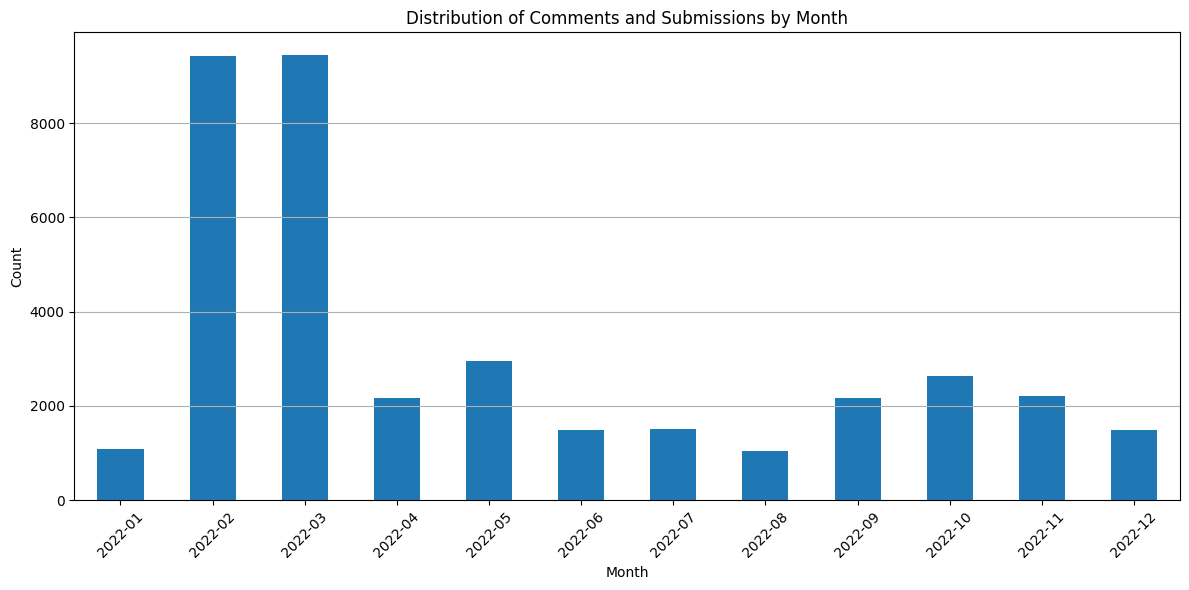

In [51]:
# plot distribution of comments and submissions by month 
date_month.value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Comments and Submissions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [52]:
data_comments = comments[['id', 'body', 'month', 'type']].rename(columns={'body': 'text', 'month': 'date'})
print(data_comments.head())
print(data_comments.shape)
data_submissions = submissions[['id', 'selftext', 'month', 'type']].rename(columns={'selftext': 'text', 'month': 'date'})
print(data_submissions.head())
print(data_submissions.shape)

# concatenate the two dataframes
data = pd.concat([data_comments, data_submissions], ignore_index=True)
data.columns = ['id', 'text', 'month', 'type']
print(data.head())
print(data.shape)

        id                                               text     date type
0  hqu6678  Eu não coloco a tua experiência em causa, mas ...  2022-01    C
1  hqu66rn  &gt;Farmaajo tem sido apoiado por muito tempo ...  2022-01    C
2  hquhhht  O que é dar certo? Porque pensa bem, o país er...  2022-01    C
3  hqv6rub  O embargo é dos EUA. Eles podem fazer negócios...  2022-01    C
4  hqvk4xj  a Ucrânia voltar ao seu estado natural de naçã...  2022-01    C
(36854, 4)
       id                                               text     date type
0  s2xl48  Conclamo meus colegas redditors a ouvirem/vere...  2022-01    S
1  s72yze  \- Apoio a Russia. Lutaria se pedissem.   \n\-...  2022-01    S
2  s7fnwt  Olhem o vídeo, por exemplo, de uma matéria fal...  2022-01    S
3  s80kun   Só pra saber q eu n sou o único vendo isso!? ...  2022-01    S
4  sa2q4t  Na internet já vi vários comentários de ucrani...  2022-01    S
(729, 4)
        id                                               text    month typ

In [53]:
print(stopwords.words('portuguese')[:30])

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles']


### Pre-process

In [54]:
def preprocess_text(text):
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("utf-8")
    
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    return text.strip()

data['text'] = data['text'].apply(preprocess_text)

### Pre-calculate embeddings

In [55]:
docs = data['text'].tolist()
timestamps = data['month'].tolist()

embeddings_path = "embeddings.npy"

if os.path.exists(embeddings_path):
    embeddings = np.load(embeddings_path)
    print("Embeddings carregadas do disco.")
else:
    embedding_model = SentenceTransformer("PORTULAN/serafim-100m-portuguese-pt-sentence-encoder")
    embeddings = embedding_model.encode(docs, show_progress_bar=True)
    np.save(embeddings_path, embeddings)
    print("Embeddings calculadas e salvas no disco.")

Embeddings carregadas do disco.


### Stopwords and vectorizer

In [56]:
stopwords_pt = list(stopwords.words("portuguese"))
# apply the same preprocessing to the stopwords
stopwords_pt = [preprocess_text(word) for word in stopwords_pt]
stopwords_en = list(stopwords.words("english"))
my_stopwords = ['pra', 'gt', 'vai', 'ta', 'pq', 'vc']
final_stopwords = stopwords_pt + stopwords_en + my_stopwords


vectorizer = CountVectorizer(
    ngram_range=(1,2), 
    stop_words=final_stopwords,
    max_df=0.8,
    min_df=1
)

### UMAP Dimension Reduction

In [57]:
umap_model = UMAP(
    n_neighbors=15, 
    n_components=10, 
    min_dist=0.0, 
    metric='cosine', 
    random_state=13
)

### HDBSCAN clustering

In [58]:
hdbscan_model = HDBSCAN(
    min_cluster_size=500, 
    metric='euclidean', 
    cluster_selection_method='eom', 
    prediction_data=True, 
)

In [59]:
topic_model = BERTopic(
    vectorizer_model=vectorizer, 
    calculate_probabilities=True, 
    umap_model=umap_model,
    hdbscan_model= hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)

2025-07-04 12:00:04,674 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-04 12:00:24,606 - BERTopic - Dimensionality - Completed ✓
2025-07-04 12:00:24,607 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-04 12:00:35,676 - BERTopic - Cluster - Completed ✓
2025-07-04 12:00:35,685 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-04 12:00:40,747 - BERTopic - Representation - Completed ✓


In [60]:
### value counts of topics
print(pd.Series(topics).value_counts().sort_index())

-1    27031
 0     2815
 1     2637
 2     2122
 3     1697
 4      765
 5      516
Name: count, dtype: int64


In [61]:
topic_model.visualize_barchart()

In [63]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)

12it [02:27, 12.33s/it]


In [64]:
topic_model.visualize_topics_over_time(topics_over_time)

In [65]:
topic_model.visualize_hierarchy()

In [70]:
topic_model.visualize_heatmap()

In [69]:
topic_model.get_representative_docs(0)

['a russia ja assinou um acordo de nao agressao com a ucrania e o quebrou  qualquer acordo com a russia e so um pedaco de papel  seja um acordo de nao agressao ou de ajuda em uma possivel invasao  alem disso voce descreveu exatamente a atuacao da otan  defender o territorio da ucrania em caso de um ataque estrangeiro  ou seja  voce esta defendendo que a ucrania entre para a otan \n\n  na vdd eu defendo uma coisa um pouco diferente   no caso de um conflito entre otan e russia  ucrania se mantem neutra  mas pra garantir a neutralidade  otan  russia e ucrania teriam q fazer esse acordo a tres onde cada um se compromete a defender a ucrania contra o outro  assim cada um deles ia pensar 2 vezes antes de agir    \n\n\nquais acoes do zelensky ocasionaram a guerra  pedir ajuda e tentar desesperadamente uma adesao a otan depois do putin colocar 200k soldados ao logo de toda borda da ucrania com a russia e a bielorrussia  voce e daqueles caras que acha que um pais move toda a maquina de guerra d

In [72]:
topic_model.get_representative_docs(1)

['que zona aquela reuniao  ninguem respeita a vez do outro falar  o primeiro conselheiro que foi fazer pergunta  que parecia o mais preparado para a reuniao  que levou varias perguntas escritas  ficou a reuniao inteira em pe sendo interrompido o tempo todo  sem deixarem ele concluir \n\nsera que eles nao conseguem organizar uma inscricao para perguntas  \n\n amp  x200b \n\nsobre o conteudo em si  nao vi nenhuma grande novidade  o ssr e o pedro da xp falaram muito e nao disseram nada  so enrolacao  que meu pai e cruzeirense  que eu sou cruzeirense  que eu lembro do jogo de 1996  que atacaram minha reputacao  que a imprensa quer tumultuar  etc  so jogaram para a galera  informacao concreta mesmo sobre o negocio  que era o motivo da reuniao  quase nada \n\n amp  x200b \n\nnas perguntas  so saiam pela tangente  o conselheiro pergunta  por qual valor os 180 atletas da base foram avaliados para entrar no negocio  resposta do ssr  deixa eu te dar um exemplo  ano passado fulano de tal era uma 

In [73]:
topic_model.get_representative_docs(2)

['isso nao tem nada a ver com o jegues   e dolar baixo e bom so pra investidor internacional e rico que viaja pra fora  inflacao continua alta  inclusive e o indice em disparada mais investido na b3 desde fevereiro  ou seja  pra 80  dos brs fudidos e desesperados  nao muda nada \n\nalem disso  o brasil esta com uma taxa de juros reais altissima  so perde pra russia no fechamento de marco  que esta em guerra  pelo fato de estar com o juro real la em cima  o fluxo de dolar aumenta no pais  pois entra dinheiro internacional aqui por duas vias  investimento e venda de commodities \n\nas reservas de dolares do bc explodiram e estao lotadas  porem  80  dos brs sao pobres fudidos  desesperados para comer  abastecer o carro e pagar contas  ninguem tem dinheiro pra comprar dolares nem pensa em viajar pra fora  o volume cresce nos bancos e o preco cai  oferta altissima e demanda baixissima  indicador basico do capitalismo  \n\nvoce atualmente esta mais fudido do que jamais esteve  mas e alienado

In [74]:
topic_model.get_representative_docs(3)

['existem nazistas na ucrania  russia aproveitou isso para criar campanha de desinformacao \n\no detalhe mais interessante e que os grupos separatistas financiados pela russia tem ligacoes com neo nazis tambem  tres batalhoes neo nazi e um partido politico ligado a lideranca das regioes separatistas',
 'gt  filha essa que nao teve quase nenhuma convivencia ou vinculo afetivo com ele   khrushchev amigo pessoal de stalin  tu sabe quem foi khrushchev \n\nah  voce nao sabe nada da vida do stalin  e melhor nao se manifestar do que passar vergonha  nesses casos  se quiser  posso recomendar leituras e biografias  \n\n gt   voce acha que os caras aceitariam integrar o exercito se nao existisse algum tipo de regalia  \n\nmas e obvio  o motivo de formacao da unidade nao foi a propagacao do nazismo pelo mundo  foi a invasao da ucrania pela russia e a manutencao da integridade territorial do pais  e equipamento militar nao surge do chao  o poder de barganha esta com o ente estatal  \n\n gt  e pres

In [75]:
topic_model.get_representative_docs(4)

['esse sub aqui e cheio de viuvas da ucrania  kkkkkk\nha uma coluna blindada ja cercando a cidade  e melhor essa galera ai ficar em casa ou vao entrar no cacete   \npau no cu da otan',
 'bota uma faccao na ucrania  eles botam os russos e os ucranianos pra correr\n\ne ainda anexam a ucrania ao rio de janeiro',
 'aqui tem um livemap dos acontecimentos da ucrania  ali da pra ver os conflitos armados  explosoes  etc  da pra ter uma ideia geral no que esta acontecendo   liveuamap  \n\nareas em vermelho sao as tomadas pelos russos  tu clica no mapa e ai abra o videozinho com a geotag da regiao']

In [76]:
topic_model.get_representative_docs(5)

['porque a invasao se deu pela provocacao ameaca do   imperio estaduniense   cercando o   quintal deles    \n\n gt  imperio estaduniense   \n gt   \n gt  quintal deles  \n\npera     \nimperialismo e ruim   mas a russia tem direito a quintal  no pais do outros   explica ai',
 'o cara ta numa guerra contra a russia  a russia deseja literalmente a extincao do pais  pessoas da favores da russia sao literalmente a favores da extincao do pais  ou seja completamente antidemocratico  me diga onde isso e errado ou antidemocratico',
 'que tal comecarmos com o lado que esta mais errado e o que inicialmente invadiu outro pais uns anos atras com objetivos de anexacao de territorio  e agora esta dizendo que vai fazer de novo  o que de fato iniciaria  mais uma  guerra que vai resultar na morte de milhares e sofrimento de milhoes \n\nde novo  se a russia estivesse fazendo propaganda e dando golpes e contra golpes como os eua seria escroto no mesmo nivel  mas eu escolho facilmente eles fazendo uma disp